# Cell 1: Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D # For custom legend handles
from datetime import date # For type hinting if using dates
import logging

import pandas as pd
pd.set_option('display.max_columns', None)


# Configure logging (set level, format, etc.) - Basic example
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True) # force=True might be needed in notebooks

# Add functions directory to path to import custom modules
# Assuming the notebook is run from the project root directory
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib
# Import the data fetching and loading functions
from functions.data_fetching.earthquake_data import fetch_and_load_earthquake_data
from functions.data_fetching.plate_data import load_plate_boundaries
from functions.data_fetching.natural_earth_downloader import load_natural_earth_data
import functions.data_processing
# Import the plotting function
import functions.plotting

logging.info("Libraries and custom functions imported.")

2025-04-08 12:18:58,086 - INFO - Libraries and custom functions imported.


# Cell 2: Define Parameters

In [2]:
# Define the minimum magnitude for earthquake data
min_eq_magnitude = 1.0

# Define target CRS (used by loading functions by default)
target_crs_epsg = "EPSG:4326"

# Define date range (optional, defaults in function are ~last year)
# Set to None if not using specific dates, otherwise define as string or date object
start_date = "2020-01-01" # Example: "2024-01-01" or date(2024, 1, 1)
end_date =  "2024-12-31"   # Example: "2024-12-31" or date(2024, 12, 31)

# Cell 3: Load Data using Functions

In [3]:
# Load Earthquake Data
logging.info(f"Loading earthquake data (min magnitude: {min_eq_magnitude}, target CRS: {target_crs_epsg})...")
earthquake_gdf = fetch_and_load_earthquake_data(
    min_magnitude=min_eq_magnitude,
    target_crs=target_crs_epsg,
    start_date=start_date, # Pass defined start_date
    end_date=end_date      # Pass defined end_date
)
# drop columns we don't need
earthquake_gdf.drop(columns=['tz', 'url', 'detail','title', 'updated','sources','ids','types'], inplace=True)
if earthquake_gdf is not None:
    logging.info(f"-> Successfully loaded {len(earthquake_gdf)} earthquakes. CRS: {earthquake_gdf.crs}")
else:
    logging.error("-> Failed to load earthquake data.")

# Load Plate Boundary Data
logging.info(f"\nLoading tectonic plate boundary data (target CRS: {target_crs_epsg})...")
plate_gdf = load_plate_boundaries(target_crs=target_crs_epsg)
if plate_gdf is not None:
    logging.info(f"-> Successfully loaded {len(plate_gdf)} plate boundary features. CRS: {plate_gdf.crs}")
else:
    logging.error("-> Failed to load plate boundary data.")

# Load Natural Earth Data
logging.info(f"\nLoading Natural Earth 50m countries and 10m lakes data (target CRS: {target_crs_epsg})...")
natural_earth_data = load_natural_earth_data(target_crs=target_crs_epsg)
ne_countries_gdf = natural_earth_data.get('countries') # Changed key and variable name
ne_lakes_gdf = natural_earth_data.get('lakes')

if ne_countries_gdf is not None:
    logging.info(f"-> Successfully loaded {len(ne_countries_gdf)} countries. CRS: {ne_countries_gdf.crs}")
else:
    logging.error("-> Failed to load Natural Earth countries.")

if ne_lakes_gdf is not None:
    logging.info(f"-> Successfully loaded {len(ne_lakes_gdf)} lakes. CRS: {ne_lakes_gdf.crs}")
else:
    logging.error("-> Failed to load Natural Earth lakes.")

2025-04-08 12:18:58,658 - INFO - Loading earthquake data (min magnitude: 1.0, target CRS: EPSG:4326)...
2025-04-08 12:18:58,666 - INFO - Processing earthquake data from 2020-01-01 to 2024-12-31 (inclusive)...
2025-04-08 12:18:58,757 - INFO - All daily files already exist locally.
2025-04-08 12:18:58,757 - INFO - Loading daily GeoJSON files...
2025-04-08 12:21:10,409 - INFO - Concatenating data from 1827 daily files...
2025-04-08 12:21:11,911 - INFO - Successfully loaded and combined 552787 total earthquakes.
2025-04-08 12:21:11,924 - INFO - Reprojecting combined earthquake data from EPSG:4979 to EPSG:4326...
2025-04-08 12:21:13,833 - INFO - Reprojection successful. Final CRS: EPSG:4326
2025-04-08 12:21:14,746 - INFO - -> Successfully loaded 552787 earthquakes. CRS: EPSG:4326
2025-04-08 12:21:14,746 - INFO - 
Loading tectonic plate boundary data (target CRS: EPSG:4326)...
2025-04-08 12:21:14,746 - INFO - Found existing combined plate boundary file: resources\plate_boundaries\combined_pl

# Cell 4: Check Loaded Data

In [4]:
# Verify if essential data for plotting was loaded successfully
can_plot_plates_eq = all(gdf is not None for gdf in [plate_gdf, earthquake_gdf])
can_plot_ne = all(gdf is not None for gdf in [ne_countries_gdf, ne_lakes_gdf]) # Basemap is optional, updated variable

if not can_plot_plates_eq:
    logging.error("Error: Cannot proceed with plotting as Plate Boundary or Earthquake data failed to load.")
else:
    logging.info("Essential data (Plates, Earthquakes) loaded successfully.")
    if not can_plot_ne:
        logging.warning("Warning: Natural Earth basemap data failed to load. Plot will be generated without basemap.")
    else:
        logging.info("Natural Earth basemap data loaded successfully.")

2025-04-08 12:21:15,530 - INFO - Essential data (Plates, Earthquakes) loaded successfully.
2025-04-08 12:21:15,531 - INFO - Natural Earth basemap data loaded successfully.


# Calculate the UTM Zone for every earthquak point, project the point to that utm zone in a new column

In [5]:
import pandas as pd # Added for pd.isna
from shapely.geometry import Point
import geopandas as gpd
import math
import swifter # Import swifter
import logging # Make sure logging is configured elsewhere

from functions import data_processing



# Make our earthquake location with a depth a 2d point. be efficient for testing and only do this if we haven't done it before
if not earthquake_gdf.empty and 'geometry' in earthquake_gdf.columns and earthquake_gdf['geometry'].iloc[0] is not None and hasattr(earthquake_gdf['geometry'].iloc[0], 'has_z') and earthquake_gdf['geometry'].iloc[0].has_z:
    logging.info("earthquake_gdf geometry is 3D. Converting to 2D.")
    # Ensure we only apply to actual geometry objects, handle None
    earthquake_gdf['geometry'] = earthquake_gdf['geometry'].swifter.apply(
        lambda geom: Point(geom.x, geom.y) if geom and hasattr(geom, 'x') else None
    )
else:
    logging.info("earthquake_gdf geometry is not 3D or conversion not needed. Skipping conversion.")

# --- Modified Apply Call ---
logging.info("Calculating UTM info and reprojecting geometry using swifter...")

# Apply the combined function row-wise using swifter
# Pass the source_crs as an argument

earthquake_with_utm_gdf = earthquake_gdf.query('mag>1').copy()
result_series = earthquake_with_utm_gdf.swifter.apply(
    data_processing.get_utm_info_and_reproject,
    source_crs=earthquake_with_utm_gdf.crs, # Pass the source CRS here
    axis=1
)
earthquake_with_utm_gdf[['utm_zone', 'utm_epsg', 'utm_geometry']] = gpd.GeoDataFrame(
    result_series.tolist(),
    index=earthquake_with_utm_gdf.index
)
earthquake_with_utm_gdf.head()

2025-04-08 12:21:15,627 - INFO - earthquake_gdf geometry is 3D. Converting to 2D.


Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

2025-04-08 12:22:39,984 - INFO - Calculating UTM info and reprojecting geometry using swifter...


Pandas Apply:   0%|          | 0/535961 [00:00<?, ?it/s]

,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry
0,ak02021ksej,1.30,"38 km SE of Tanana, Alaska",1577923094766,NaN,NaN,NaN,None,reviewed,0,26,ak,02021ksej,NaN,NaN,0.81,NaN,ml,earthquake,POINT (-151.5952 64.8922),2020-01-01,5N,EPSG:32605,POINT (566508.2623993153 7197178.920848711)
1,nc73322376,1.63,"10km ENE of Blackhawk, CA",1577922964240,NaN,NaN,NaN,None,reviewed,0,41,nc,73322376,24.0,0.03565,0.09,129.0,md,earthquake,POINT (-121.79433 37.8455),2020-01-01,10N,EPSG:32610,POINT (606077.9638517055 4189357.967278359)
2,nc73322371,1.46,"14km S of Tres Pinos, CA",1577922767220,NaN,NaN,NaN,None,reviewed,0,33,nc,73322371,20.0,0.04473,0.07,88.0,md,earthquake,POINT (-121.2945 36.67067),2020-01-01,10N,EPSG:32610,POINT (652407.1467748537 4059694.2764252787)
3,pr2020001292,1.56,"7 km SW of Tallaboa, Puerto Rico",1577922752460,NaN,NaN,NaN,None,reviewed,0,37,pr,2020001292,3.0,0.12060,0.17,351.0,md,earthquake,POINT (-66.7623 17.9455),2020-01-01,19N,EPSG:32619,POINT (737010.5971063226 1985582.428257147)
4,pr2020001291,1.78,"6 km SSE of Guánica, Puerto Rico",1577922719530,NaN,NaN,NaN,None,reviewed,0,49,pr,2020001291,4.0,0.06170,0.62,275.0,md,earthquake,POINT (-66.884 17.9136),2020-01-01,19N,EPSG:32619,POINT (724155.7383510026 1981900.1717897344)


In [6]:
import geopandas as gpd
from functions.spatial_analysis import calculate_distance_to_plate

earthquake_gdf_with_distances = gpd.GeoDataFrame(calculate_distance_to_plate(earthquake_with_utm_gdf, plate_gdf, max_workers=4, log_level='NONE'))

earthquake_gdf_with_distances.head()

2025-04-08 13:22:52,662 - INFO - --- Finished calculate_distance_to_plate ---


,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry,distance_to_plate,nearest_plate_strnum,nearest_plate_platecode,nearest_plate_geogdesc,nearest_plate_boundary_t
0,ak02021ksej,1.30,"38 km SE of Tanana, Alaska",1577923094766,NaN,NaN,NaN,None,reviewed,0,26,ak,02021ksej,NaN,NaN,0.81,NaN,ml,earthquake,POINT (-151.5952 64.8922),2020-01-01,5N,EPSG:32605,POINT (566508.2624 7197178.92085),NaN,<NA>,<NA>,<NA>,<NA>
1,nc73322376,1.63,"10km ENE of Blackhawk, CA",1577922964240,NaN,NaN,NaN,None,reviewed,0,41,nc,73322376,24.0,0.03565,0.09,129.0,md,earthquake,POINT (-121.79433 37.8455),2020-01-01,10N,EPSG:32610,POINT (606077.96385 4189357.96728),1.247759e+06,33,501,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",ridge
2,nc73322371,1.46,"14km S of Tres Pinos, CA",1577922767220,NaN,NaN,NaN,None,reviewed,0,33,nc,73322371,20.0,0.04473,0.07,88.0,md,earthquake,POINT (-121.2945 36.67067),2020-01-01,10N,EPSG:32610,POINT (652407.14677 4059694.27643),1.294050e+06,33,501,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",ridge
3,pr2020001292,1.56,"7 km SW of Tallaboa, Puerto Rico",1577922752460,NaN,NaN,NaN,None,reviewed,0,37,pr,2020001292,3.0,0.12060,0.17,351.0,md,earthquake,POINT (-66.7623 17.9455),2020-01-01,19N,EPSG:32619,POINT (737010.59711 1985582.42826),8.947327e+05,191,201,"BOCONO FAULT, NW SOUTH AMERICA",transform
4,pr2020001291,1.78,"6 km SSE of Guánica, Puerto Rico",1577922719530,NaN,NaN,NaN,None,reviewed,0,49,pr,2020001291,4.0,0.06170,0.62,275.0,md,earthquake,POINT (-66.884 17.9136),2020-01-01,19N,EPSG:32619,POINT (724155.73835 1981900.17179),8.880889e+05,191,201,"BOCONO FAULT, NW SOUTH AMERICA",transform


2025-04-08 13:22:53,529 - INFO - 
Generating plot...
2025-04-08 13:22:53,585 - INFO - Plotting Natural Earth layers...
2025-04-08 13:22:53,587 - INFO - Plotting land boundaries...
2025-04-08 13:22:54,434 - INFO - Filtering lakes to top 100 by area (using original CRS area)...
2025-04-08 13:22:54,434 - INFO - Original lake CRS (WGS 84) is geographic.
2025-04-08 13:22:54,434 - INFO - Direct area calculation (degrees-squared) is unsuitable for size comparison.
2025-04-08 13:22:54,436 - INFO - Attempting temporary reprojection to EPSG:3857 (Web Mercator) for approximate area calculation.
2025-04-08 13:22:54,536 - INFO - Successfully reprojected temporarily to very roughly approximate area for ranking purposes only.
2025-04-08 13:22:54,544 - INFO - Plotting 100 largest lakes.
2025-04-08 13:22:54,952 - INFO - Plotting plate boundaries by type...
2025-04-08 13:22:55,732 - INFO - Plotted boundary types found: ['ridge' 'transform' 'trench']
2025-04-08 13:22:55,744 - INFO - Plotting earthquake d

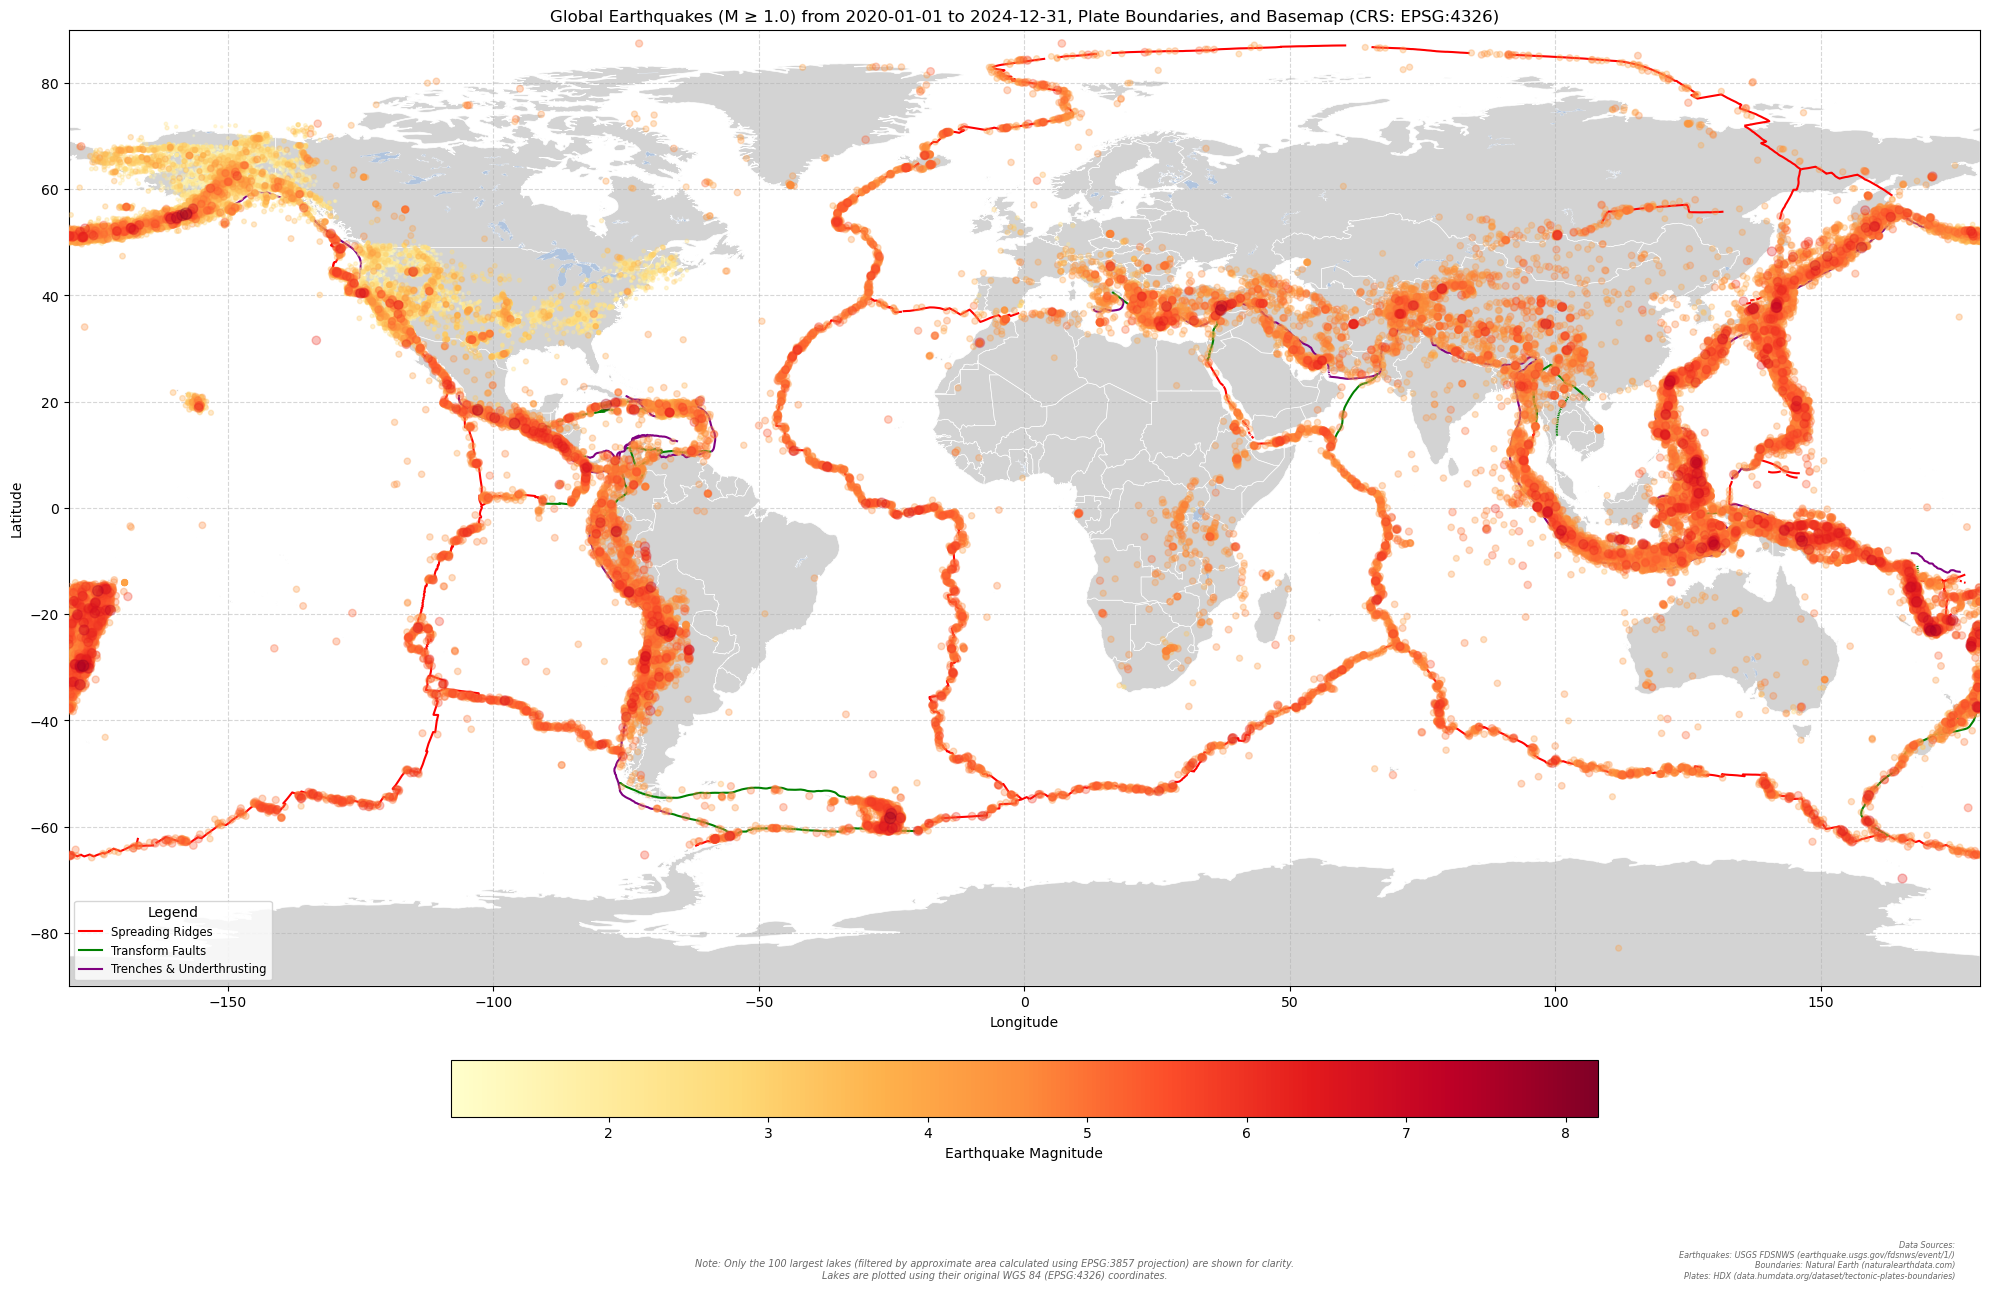

2025-04-08 13:23:54,459 - INFO - Plot displayed.


In [7]:
if can_plot_plates_eq:
    functions.plotting.plot_earthquake_plate_map( # Ensure using the reloaded module
        earthquake_gdf=earthquake_gdf_with_distances,
        plate_gdf=plate_gdf,
        ne_land_gdf=ne_countries_gdf, # Pass countries to the renamed parameter
        ne_lakes_gdf=ne_lakes_gdf,
        min_magnitude=min_eq_magnitude,
        start_date=start_date, # Pass the defined start_date (could be None)
        end_date=end_date,     # Pass the defined end_date (could be None)
        target_crs_epsg=target_crs_epsg
    )
else:
    logging.warning("Skipping plot generation due to data loading errors.")

In [8]:
earthquake_gdf_with_distances.query('distance_to_plate>0').head()

,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry,distance_to_plate,nearest_plate_strnum,nearest_plate_platecode,nearest_plate_geogdesc,nearest_plate_boundary_t
1,nc73322376,1.63,"10km ENE of Blackhawk, CA",1577922964240,NaN,NaN,NaN,None,reviewed,0,41,nc,73322376,24.0,0.03565,0.09,129.0,md,earthquake,POINT (-121.79433 37.8455),2020-01-01,10N,EPSG:32610,POINT (606077.96385 4189357.96728),1.247759e+06,33,501,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",ridge
2,nc73322371,1.46,"14km S of Tres Pinos, CA",1577922767220,NaN,NaN,NaN,None,reviewed,0,33,nc,73322371,20.0,0.04473,0.07,88.0,md,earthquake,POINT (-121.2945 36.67067),2020-01-01,10N,EPSG:32610,POINT (652407.14677 4059694.27643),1.294050e+06,33,501,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",ridge
3,pr2020001292,1.56,"7 km SW of Tallaboa, Puerto Rico",1577922752460,NaN,NaN,NaN,None,reviewed,0,37,pr,2020001292,3.0,0.12060,0.17,351.0,md,earthquake,POINT (-66.7623 17.9455),2020-01-01,19N,EPSG:32619,POINT (737010.59711 1985582.42826),8.947327e+05,191,201,"BOCONO FAULT, NW SOUTH AMERICA",transform
4,pr2020001291,1.78,"6 km SSE of Guánica, Puerto Rico",1577922719530,NaN,NaN,NaN,None,reviewed,0,49,pr,2020001291,4.0,0.06170,0.62,275.0,md,earthquake,POINT (-66.884 17.9136),2020-01-01,19N,EPSG:32619,POINT (724155.73835 1981900.17179),8.880889e+05,191,201,"BOCONO FAULT, NW SOUTH AMERICA",transform
5,us70006tcs,4.40,"201 km SSE of Tual, Indonesia",1577922604863,NaN,NaN,NaN,None,reviewed,0,298,us,70006tcs,NaN,2.39800,0.57,144.0,mb,earthquake,POINT (133.6026 -7.2438),2020-01-01,53S,EPSG:32753,POINT (345722.3208 9199062.48991),2.122223e+06,2,201,SOUTH ATLANTIC RIDGE,ridge


In [9]:
# Preview the plate ridgeds in order of activity
earthquake_gdf_with_distances.groupby('nearest_plate_geogdesc').size().reset_index(name='count').sort_values('count', ascending=False)

,nearest_plate_geogdesc,count
4,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",162833
1,"BOCONO FAULT, NW SOUTH AMERICA",29081
28,SOUTH ATLANTIC RIDGE,26746
34,"VITIAZ TRENCH, WEST PACIFIC",20892
9,JAVA TRENCH (ACTIVE SUBDUCTION) (C. PART FROM SU,19764
16,PACIFIC-COCOS SPREADING CENTER,18833
30,SS FAULT THROUGH N. SULAWESI (PALU FAULT),7586
17,PACIFIC-NAZCA SPREADING CENTER,3146
23,PHILIPPINE TRENCH,3064
31,SUMATRA FAULT (RIGHT-LATERAL S. SUMATRA),3002


# Distance From Ridge and Magnitude Analysis and Exploration

In [10]:
# counts by ridge type
earthquake_gdf_with_distances.groupby('nearest_plate_boundary_t').size().reset_index(name='count').sort_values('count', ascending=False)

,nearest_plate_boundary_t,count
0,ridge,212864
2,trench,51379
1,transform,44569


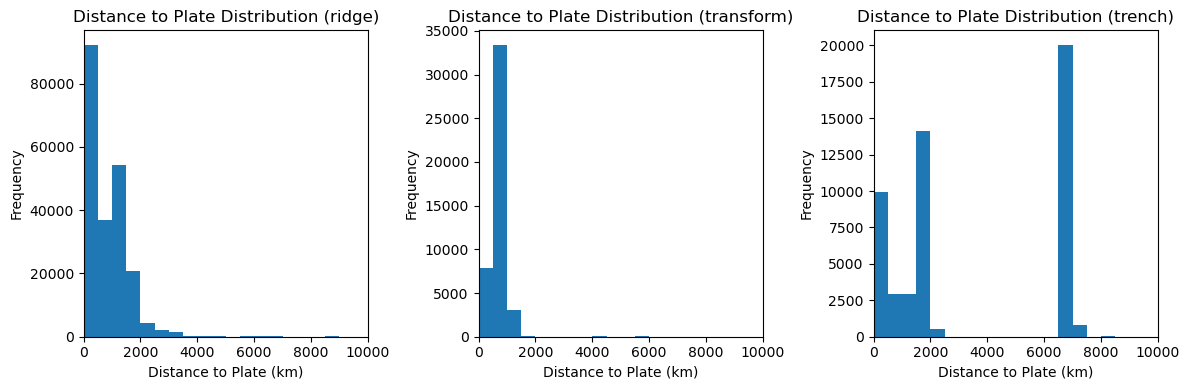

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming earthquake_gdf_with_distances is your DataFrame

# Convert distance to kilometers
earthquake_gdf_with_distances['distance_to_plate_km'] = earthquake_gdf_with_distances['distance_to_plate'] / 1000

# Get unique boundary types, excluding those where *all* distances are NaN
unique_boundaries = earthquake_gdf_with_distances.dropna(subset=['distance_to_plate_km'])['nearest_plate_boundary_t'].unique()
num_plots = len(unique_boundaries)

# Create the figure and axes for the horizontal plots
fig, axes = plt.subplots(1, num_plots, figsize=(12, 4))  # 1 row, num_plots columns, adjust figsize as needed
if num_plots == 1:  # Handle case where there's only one subplot (axes becomes a single Axes object)
    axes = [axes]  # Wrap in a list to make it iterable

# Iterate through the boundary types and create the histograms
for i, boundary_type in enumerate(unique_boundaries):
    df_subset = earthquake_gdf_with_distances[earthquake_gdf_with_distances['nearest_plate_boundary_t'] == boundary_type].dropna(subset=['distance_to_plate_km'])

    axes[i].hist(df_subset['distance_to_plate_km'], bins=20, range=(0, 10000))  # Adjust number of bins as needed, set range
    axes[i].set_title(f"Distance to Plate Distribution ({boundary_type})")
    axes[i].set_xlabel("Distance to Plate (km)")
    axes[i].set_ylabel("Frequency")
    axes[i].set_xlim(0, 10000)  # Set x-axis limit

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\Hannah Miller Young\AppData\Local\Temp\ipykernel_18928\2677506604.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


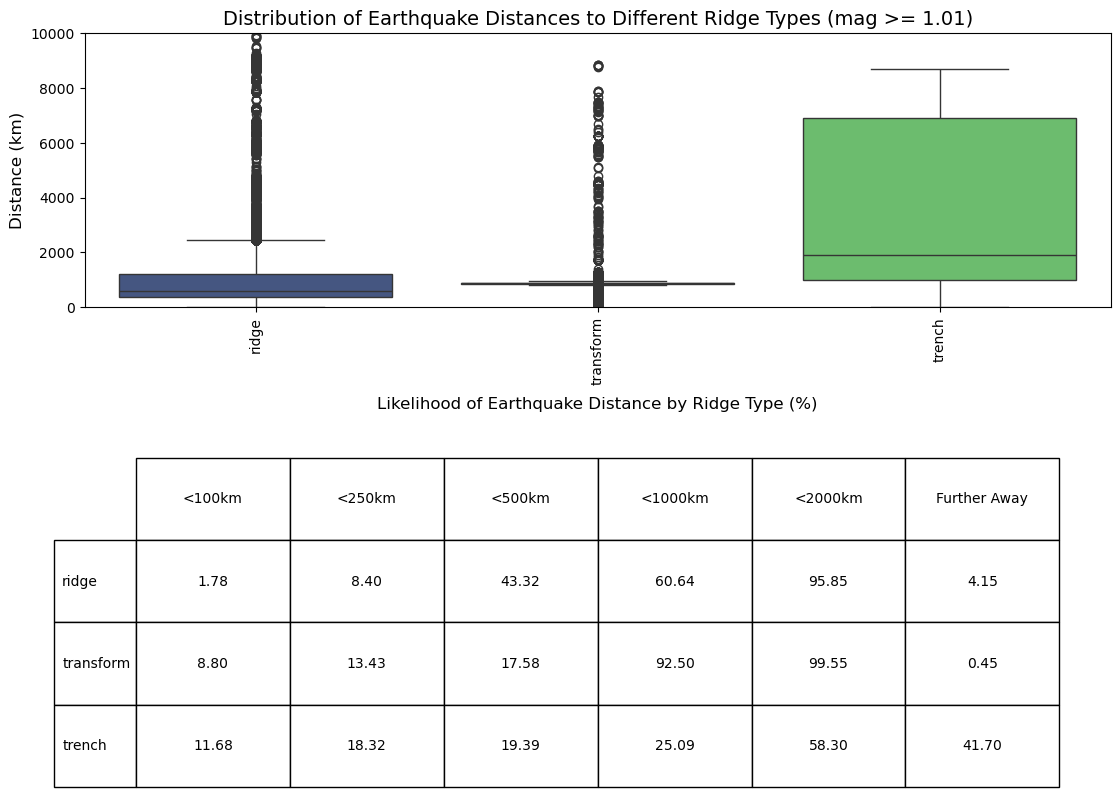

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For example data

## --- Make sure calculate_ridge_distance_likelihood is defined as before ---
def calculate_ridge_distance_likelihood(df, distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_boundary_t', distance_thresholds=[100, 250, 500, 1000, 2000]):
    """
    Calculates the likelihood (percentage) of earthquakes occurring within specified distance thresholds for each ridge type. Handles empty input DataFrame.
    (Function content remains the same as the robust version from previous steps)
    """
    if df.empty:
        cols = [f"<{th}km" for th in distance_thresholds] + ["Further Away"]
        return pd.DataFrame(columns=cols)
    df_calc = df.copy(); df_calc = df_calc.dropna(subset=[distance_column, boundary_type_column])
    if df_calc.empty:
        cols = [f"<{th}km" for th in distance_thresholds] + ["Further Away"]; return pd.DataFrame(columns=cols)
    ridge_types = df_calc[boundary_type_column].unique()
    if len(ridge_types) == 0:
         cols = [f"<{th}km" for th in distance_thresholds] + ["Further Away"]; return pd.DataFrame(columns=cols)
    results = {}
    for ridge_type in ridge_types:
        ridge_data = df_calc[df_calc[boundary_type_column] == ridge_type][distance_column]; total_count = len(ridge_data)
        results[ridge_type] = {}
        if total_count == 0:
            likelihood_further = 0.0; results[ridge_type] = {f"<{threshold}km": 0.0 for threshold in distance_thresholds}
        else:
            for threshold in distance_thresholds: results[ridge_type][f"<{threshold}km"] = (len(ridge_data[ridge_data <= threshold]) / total_count) * 100
            likelihood_further = (len(ridge_data[ridge_data > distance_thresholds[-1]]) / total_count) * 100
        results[ridge_type]["Further Away"] = likelihood_further
    results_df = pd.DataFrame(results).T; results_df = results_df.sort_index(); results_df.index.name = "Ridge Type"
    expected_cols = [f"<{th}km" for th in distance_thresholds] + ["Further Away"]
    for col in expected_cols:
        if col not in results_df.columns: results_df[col] = 0.0
    results_df = results_df[expected_cols]
    return results_df

def visualize_ridge_distance_likelihood_combined(
    df, distance_column='distance_to_plate',
    boundary_type_column='nearest_plate_boundary_t',
    max_distance=10000, 
    minmag=None, 
    mag_column='mag',
    distance_thresholds=[100, 250, 500, 1000, 2000],
    color_by=None # <-- New optional parameter
):
    """
    Visualizes earthquake distances (boxplot) and likelihoods (table).
    Adjusts layout for many categories, rotates labels, increases table spacing.
    Optionally colors boxplot by 'color_by' column and adds a legend.

    Args:
        df (pd.DataFrame): DataFrame with earthquake data.
        distance_column (str): Column name for distance (km).
        boundary_type_column (str): Column name for boundary type (x-axis).
        max_distance (int): Max distance for y-axis.
        minmag (float, optional): Minimum magnitude filter. Defaults to None.
        mag_column (str): Column name for magnitude. Defaults to 'mag'.
        distance_thresholds (list): Distance thresholds for likelihood calculation.
        color_by (str, optional): Column name to use for coloring the boxplot
                                   (hue). If None, color maps to x-axis category.
                                   Defaults to None.
    """

    orig_minmag = minmag

    # --- Data Preparation and Filtering ---
    df_filtered = df.copy()
    required_cols = [distance_column, boundary_type_column, mag_column]
    if color_by and color_by not in required_cols:
         required_cols.append(color_by) # Ensure color_by column is checked for NaNs

    df_filtered = df_filtered.dropna(subset=required_cols)

    if minmag is not None:
        df_filtered = df_filtered[df_filtered[mag_column] >= minmag]
        actual_minmag_used = minmag
    else:
        if df_filtered.empty:
             print("Warning: DataFrame empty after NaN drop.")
             return
        actual_minmag_used = df_filtered[mag_column].min()

    df_filtered = df_filtered[df_filtered[distance_column] <= max_distance]

    if df_filtered.empty:
        filter_mag_str = f"minmag={orig_minmag:.2f}" if orig_minmag is not None else "no minmag filter"
        print(f"Warning: No data left after filtering ({filter_mag_str}, max_distance={max_distance}).")
        return

    # --- Validate color_by column ---
    use_hue = False
    if color_by:
        if color_by in df_filtered.columns:
            use_hue = True
            print(f"Coloring boxplot by column: '{color_by}'")
        else:
            print(f"Warning: 'color_by' column '{color_by}' not found in filtered data. Ignoring.")
            color_by = None # Reset to None if invalid


    # --- Calculate Likelihoods ---
    results_df = calculate_ridge_distance_likelihood(df_filtered, distance_column, boundary_type_column, distance_thresholds)

    # --- Plotting Setup ---
    num_categories = len(df_filtered[boundary_type_column].unique())
    base_fig_width = 8
    # --- MODIFICATION: Increase width per category slightly ---
    width_per_category = 0.55 # OLD: 0.4 or 0.5. NEW: Try 0.55
    min_fig_width = 12
    fig_width = max(min_fig_width, base_fig_width + num_categories * width_per_category)
    fig_height = 13

    fig, axes = plt.subplots(
        2, 1,
        figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios': [2, 3]} # Keep table area larger
    )

    # --- Boxplot (Top Axes) ---
    plot_kwargs = {
        'x': boundary_type_column,
        'y': distance_column,
        'data': df_filtered,
        'ax': axes[0]
    }
    if use_hue:
        plot_kwargs['hue'] = color_by
        plot_kwargs['palette'] = 'Set2' # Use a categorical palette for hue
    else:
        plot_kwargs['palette'] = 'viridis' # Keep original behavior if no hue

    sns.boxplot(**plot_kwargs)

    title_minmag_str = f"{actual_minmag_used:.2f}"
    axes[0].set_title(f"Distribution of Earthquake Distances to Different Ridge Types (mag >= {title_minmag_str})", fontsize=14)
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Distance (km)", fontsize=12)
    axes[0].set_ylim(0, max_distance)
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

    # --- Add Legend if using hue ---
    if use_hue:
        # Place legend outside the top right corner of the plot
        axes[0].legend(title=color_by, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
        # Adjust right margin to make space for the legend
        right_margin = 0.85 # Shrink plot area to 85% to fit legend
    else:
        # Use more of the figure width if no legend
        right_margin = 0.98

    # --- Table (Bottom Axes) ---
    axes[1].axis('off')
    if results_df.empty:
        print("Warning: Likelihood calculation resulted in empty data. Skipping table.")
        axes[1].text(0.5, 0.5, "No likelihood data to display.", ha='center', va='center', fontsize=12)
    else:
        formatted_results_df = results_df.applymap(lambda x: f"{x:.2f}")
        axes[1].text(0.5, 0.95,
                     "Likelihood of Earthquake Distance by Ridge Type (%)",
                     ha='center', va='top', fontsize=12, transform=axes[1].transAxes)
        table_bbox = [0.05, 0.0, 0.9, 0.80]
        table = axes[1].table(cellText=formatted_results_df.values,
                              colLabels=formatted_results_df.columns,
                              rowLabels=formatted_results_df.index,
                              loc='center', cellLoc='center', bbox=table_bbox)
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 2.4) # Keep generous row spacing

    # --- Final Layout Adjustments ---
    # Adjust bottom margin for labels AND right margin for potential legend
    plt.subplots_adjust(bottom=0.30, right=right_margin)
    # Alternatively, use tight_layout with rect, which might handle margins better together
    # plt.tight_layout(rect=[0, 0.05, right_margin, 0.95]) # Adjust rect based on legend presence


    plt.show()

# Example usage (assuming 'earthquake_gdf_with_distances' DataFrame exists):
visualize_ridge_distance_likelihood_combined(earthquake_gdf_with_distances, distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_boundary_t', distance_thresholds=[100, 250, 500, 1000, 2000])

In [13]:
import pandas as pd
from scipy import stats

def analyze_ridge_likelihood_difference(df, distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_boundary_t', distance_threshold=100, ridge_type=None):
    """
    Analyzes if there is a statistically significant difference in the likelihood of earthquakes occurring within a certain distance
    of a specific ridge type compared to other ridge types.

    Args:
        df (pd.DataFrame): The DataFrame containing earthquake data and ridge information.
        distance_column (str): The name of the column containing the distance to the plate boundary (in km).
        boundary_type_column (str): The name of the column indicating the type of plate boundary.
        distance_threshold (int): The distance threshold (in km) to analyze.
        ridge_type (str, optional): The specific ridge type to compare against others. If None, the function iterates through
                                      each ridge type, comparing it against all others.

    Returns:
       dict: A dictionary of dictionaries. The outer dictionary is keyed by ridge_type.
              The inner dictionary contains the following keys:
                  - 'compared_to' (str): Ridge type being compared against.
                  - 'statistic' (float): The Mann-Whitney U statistic.
                  - 'pvalue' (float): The p-value from the Mann-Whitney U test.
                  - 'interpretation' (str): Interpretation of the statistical significance.
    """

    df = df.copy()
    df = df.dropna(subset=[distance_column, boundary_type_column])

    results = {}  # Store results for each ridge type

    # Get unique ridge types
    ridge_types = df[boundary_type_column].unique()


    if ridge_type is None: #Iterate over Ridge Types
        ridge_types_to_analyze = ridge_types
    else: # analyze one ridge type at a time
        ridge_types_to_analyze = [ridge_type]

    for ridge_type_to_analyze in ridge_types_to_analyze:

        results[ridge_type_to_analyze] = {} #Initialize dictionary

        for other_ridge_type in ridge_types: #Compare one at a time

            if ridge_type_to_analyze == other_ridge_type:
                continue #skip self

            results[ridge_type_to_analyze][other_ridge_type] = {} #Initialize the dictionary

            # Create binary variable for earthquakes within the specified distance of the current ridge type.
            is_ridge = (df[boundary_type_column] == ridge_type_to_analyze)
            is_within_threshold = (df[distance_column] <= distance_threshold)

            #Here's where you went wrong -- the groups were being compared ONLY with them, not with ALL data points for each ridge type
            ridge_group = is_within_threshold[is_ridge] #Only where it IS that ridge type and if it's W/IN distance
            other_group = is_within_threshold[df[boundary_type_column] == other_ridge_type] #

            if len(ridge_group) == 0 or len(other_group) == 0:
                results[ridge_type_to_analyze][other_ridge_type]['compared_to'] = other_ridge_type
                results[ridge_type_to_analyze][other_ridge_type]['statistic'] = None
                results[ridge_type_to_analyze][other_ridge_type]['pvalue'] = None
                results[ridge_type_to_analyze][other_ridge_type]['interpretation'] = "Insufficient data"
                continue  # Skip the test if either group is empty

            # Perform Mann-Whitney U test
            try:
                u_statistic, p_value = stats.mannwhitneyu(ridge_group, other_group, alternative='greater')
            except ValueError as e:
                results[ridge_type_to_analyze][other_ridge_type]['compared_to'] = other_ridge_type
                results[ridge_type_to_analyze][other_ridge_type]['statistic'] = None
                results[ridge_type_to_analyze][other_ridge_type]['pvalue'] = None
                results[ridge_type_to_analyze][other_ridge_type]['interpretation'] = f"Error performing test: {e}"
                continue

            # Interpretation based on p-value
            alpha = 0.05
            if p_value < alpha:
                results[ridge_type_to_analyze][other_ridge_type]['compared_to'] = other_ridge_type
                results[ridge_type_to_analyze][other_ridge_type]['statistic'] = u_statistic
                results[ridge_type_to_analyze][other_ridge_type]['pvalue'] = p_value
                results[ridge_type_to_analyze][other_ridge_type]['interpretation'] = f"Earthquakes are significantly more likely to occur within {distance_threshold}km of {ridge_type_to_analyze} compared to {other_ridge_type}."
            else:
                results[ridge_type_to_analyze][other_ridge_type]['compared_to'] = other_ridge_type
                results[ridge_type_to_analyze][other_ridge_type]['statistic'] = u_statistic
                results[ridge_type_to_analyze][other_ridge_type]['pvalue'] = p_value
                results[ridge_type_to_analyze][other_ridge_type]['interpretation'] = f"There is no significant difference in the likelihood of earthquakes occurring within {distance_threshold}km of {ridge_type_to_analyze} compared to {other_ridge_type}."

    return results

# Example Usage
results = analyze_ridge_likelihood_difference(earthquake_gdf_with_distances, distance_threshold=100) #Analyze with distance threshold as 100
for ridge_type, comparisons in results.items():
    print(f"Results for {ridge_type}:")
    for other_ridge, data in comparisons.items():
        print(f"  Compared to {other_ridge}:")
        print(f"    Statistic: {data.get('statistic')}")
        print(f"    P-value: {data.get('pvalue')}")
        print(f"    Interpretation: {data['interpretation']}")

Results for ridge:
  Compared to transform:
    Statistic: 4410723485.0
    P-value: 1.0
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 100km of ridge compared to transform.
  Compared to trench:
    Statistic: 4926931743.0
    P-value: 1.0
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 100km of ridge compared to trench.
Results for transform:
  Compared to ridge:
    Statistic: 5076412131.0
    P-value: 0.0
    Interpretation: Earthquakes are significantly more likely to occur within 100km of transform compared to ridge.
  Compared to trench:
    Statistic: 1111928881.0
    P-value: 1.0
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 100km of transform compared to trench.
Results for trench:
  Compared to ridge:
    Statistic: 6009807713.0
    P-value: 0.0
    Interpretation: Earthquakes are significantly more like

In [14]:
# Example Usage
results = analyze_ridge_likelihood_difference(earthquake_gdf_with_distances, distance_threshold=1000) #Analyze with distance threshold as 100
for ridge_type, comparisons in results.items():
    print(f"Results for {ridge_type}:")
    for other_ridge, data in comparisons.items():
        print(f"  Compared to {other_ridge}:")
        print(f"    Statistic: {data.get('statistic')}")
        print(f"    P-value: {data.get('pvalue')}")
        print(f"    Interpretation: {data['interpretation']}")

Results for ridge:
  Compared to transform:
    Statistic: 3232547859.5
    P-value: 1.0
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 1000km of ridge compared to transform.
  Compared to trench:
    Statistic: 7412428870.5
    P-value: 0.0
    Interpretation: Earthquakes are significantly more likely to occur within 1000km of ridge compared to trench.
Results for transform:
  Compared to ridge:
    Statistic: 6254587756.5
    P-value: 0.0
    Interpretation: Earthquakes are significantly more likely to occur within 1000km of transform compared to ridge.
  Compared to trench:
    Statistic: 1916713189.0
    P-value: 0.0
    Interpretation: Earthquakes are significantly more likely to occur within 1000km of transform compared to trench.
Results for trench:
  Compared to ridge:
    Statistic: 3524310585.5
    P-value: 1.0
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 1000

In [15]:
import pandas as pd
from scipy import stats

def analyze_mag_distance_correlation_by_boundary(df, mag_column='mag', distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_boundary_t'):
    """
    Calculates the Spearman rank correlation between magnitude and distance
    separately for each plate boundary type.

    Args:
        df (pd.DataFrame): The DataFrame containing earthquake data.
        mag_column (str): Name of the magnitude column.
        distance_column (str): Name of the distance (in km) column.
        boundary_type_column (str): Name of the boundary type column.

    Returns:
        dict: A dictionary where keys are boundary types and values are
              dictionaries containing 'correlation' (Spearman's rho),
              'p_value', and 'interpretation'.
              Returns None for boundary types with insufficient data.
    """

    # Drop rows with NaN in relevant columns to avoid errors
    df_clean = df.dropna(subset=[mag_column, distance_column, boundary_type_column]).copy()

    boundary_types = df_clean[boundary_type_column].unique()
    results = {}
    alpha = 0.05  # Significance level

    for b_type in boundary_types:
        subset = df_clean[df_clean[boundary_type_column] == b_type]

        # Need at least 3 data points for a meaningful correlation calculation
        if len(subset) < 3:
            results[b_type] = {
                'correlation': None,
                'p_value': None,
                'interpretation': f"Insufficient data points ({len(subset)}) for correlation."
            }
            continue

        # Calculate Spearman correlation and p-value
        try:
            correlation, p_value = stats.spearmanr(subset[mag_column], subset[distance_column])

            # Interpret the result
            interpretation = f"Spearman Correlation (rho): {correlation:.3f}, P-value: {p_value:.3g}. "
            if p_value < alpha:
                if correlation > 0.1: # Threshold for weak positive correlation
                    interpretation += f"There is a statistically significant weak-to-moderate positive correlation: higher magnitude earthquakes tend to occur slightly further from the {b_type} boundary."
                elif correlation < -0.1: # Threshold for weak negative correlation
                    interpretation += f"There is a statistically significant weak-to-moderate negative correlation: higher magnitude earthquakes tend to occur slightly closer to the {b_type} boundary."
                else:
                     interpretation += f"There is a statistically significant but very weak correlation (close to zero), suggesting little practical relationship."

            else:
                interpretation += f"There is no statistically significant correlation between magnitude and distance for the {b_type} boundary."

            results[b_type] = {
                'correlation': correlation,
                'p_value': p_value,
                'interpretation': interpretation
            }
        except Exception as e: # Catch potential errors during calculation
             results[b_type] = {
                'correlation': None,
                'p_value': None,
                'interpretation': f"Error during correlation calculation: {e}"
            }


    return results

# --- Example Usage ---
# Assuming 'earthquake_gdf_with_distances' is your DataFrame and
# 'distance_to_plate_km' column exists.

correlation_results = analyze_mag_distance_correlation_by_boundary(earthquake_gdf_with_distances)

# Print the results clearly
print("Correlation between Magnitude and Distance by Boundary Type:\n")
for boundary_type, result in correlation_results.items():
    print(f"--- {boundary_type} ---")
    if result['correlation'] is not None:
        print(f"  Spearman's rho: {result['correlation']:.3f}")
        print(f"  P-value: {result['p_value']:.3g}") # Use general format for p-value display
        print(f"  Interpretation: {result['interpretation']}")
    else:
        print(f"  {result['interpretation']}") # Print error or insufficient data message
    print("-" * (len(boundary_type) + 8) + "\n")

Correlation between Magnitude and Distance by Boundary Type:

--- ridge ---
  Spearman's rho: 0.175
  P-value: 0
  Interpretation: Spearman Correlation (rho): 0.175, P-value: 0. There is a statistically significant weak-to-moderate positive correlation: higher magnitude earthquakes tend to occur slightly further from the ridge boundary.
-------------

--- transform ---
  Spearman's rho: -0.220
  P-value: 0
  Interpretation: Spearman Correlation (rho): -0.220, P-value: 0. There is a statistically significant weak-to-moderate negative correlation: higher magnitude earthquakes tend to occur slightly closer to the transform boundary.
-----------------

--- trench ---
  Spearman's rho: -0.443
  P-value: 0
  Interpretation: Spearman Correlation (rho): -0.443, P-value: 0. There is a statistically significant weak-to-moderate negative correlation: higher magnitude earthquakes tend to occur slightly closer to the trench boundary.
--------------



# Distance From Nearest Plate Ridge and Magnitude Analysis and Exploration
***Reusing functions from above with different input column***

In [16]:
earthquake_gdf_with_distances.head()

,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry,distance_to_plate,nearest_plate_strnum,nearest_plate_platecode,nearest_plate_geogdesc,nearest_plate_boundary_t,distance_to_plate_km
0,ak02021ksej,1.30,"38 km SE of Tanana, Alaska",1577923094766,NaN,NaN,NaN,None,reviewed,0,26,ak,02021ksej,NaN,NaN,0.81,NaN,ml,earthquake,POINT (-151.5952 64.8922),2020-01-01,5N,EPSG:32605,POINT (566508.2624 7197178.92085),NaN,<NA>,<NA>,<NA>,<NA>,NaN
1,nc73322376,1.63,"10km ENE of Blackhawk, CA",1577922964240,NaN,NaN,NaN,None,reviewed,0,41,nc,73322376,24.0,0.03565,0.09,129.0,md,earthquake,POINT (-121.79433 37.8455),2020-01-01,10N,EPSG:32610,POINT (606077.96385 4189357.96728),1.247759e+06,33,501,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",ridge,1247.759356
2,nc73322371,1.46,"14km S of Tres Pinos, CA",1577922767220,NaN,NaN,NaN,None,reviewed,0,33,nc,73322371,20.0,0.04473,0.07,88.0,md,earthquake,POINT (-121.2945 36.67067),2020-01-01,10N,EPSG:32610,POINT (652407.14677 4059694.27643),1.294050e+06,33,501,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",ridge,1294.049692
3,pr2020001292,1.56,"7 km SW of Tallaboa, Puerto Rico",1577922752460,NaN,NaN,NaN,None,reviewed,0,37,pr,2020001292,3.0,0.12060,0.17,351.0,md,earthquake,POINT (-66.7623 17.9455),2020-01-01,19N,EPSG:32619,POINT (737010.59711 1985582.42826),8.947327e+05,191,201,"BOCONO FAULT, NW SOUTH AMERICA",transform,894.732660
4,pr2020001291,1.78,"6 km SSE of Guánica, Puerto Rico",1577922719530,NaN,NaN,NaN,None,reviewed,0,49,pr,2020001291,4.0,0.06170,0.62,275.0,md,earthquake,POINT (-66.884 17.9136),2020-01-01,19N,EPSG:32619,POINT (724155.73835 1981900.17179),8.880889e+05,191,201,"BOCONO FAULT, NW SOUTH AMERICA",transform,888.088906


C:\Users\Hannah Miller Young\AppData\Local\Temp\ipykernel_18928\2677506604.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


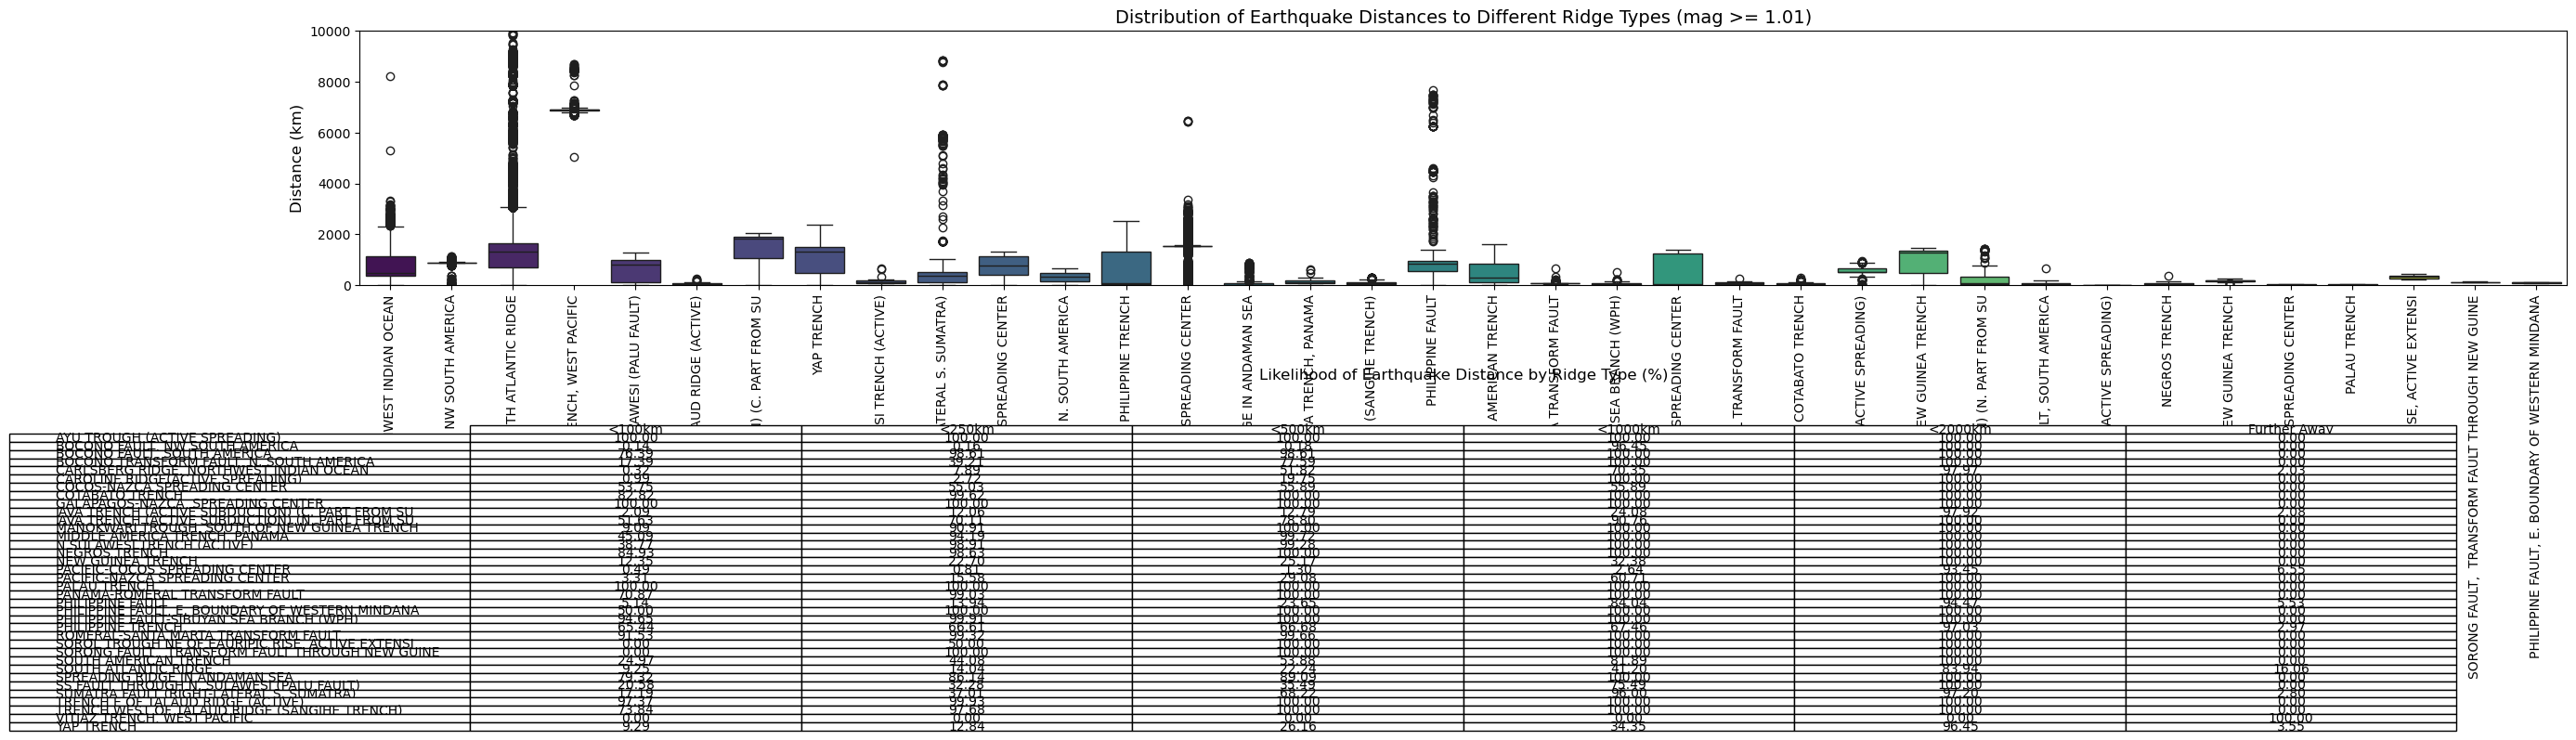

In [17]:
visualize_ridge_distance_likelihood_combined(earthquake_gdf_with_distances, distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_geogdesc', distance_thresholds=[100, 250, 500, 1000, 2000])

Coloring boxplot by column: 'nearest_plate_boundary_t'


C:\Users\Hannah Miller Young\AppData\Local\Temp\ipykernel_18928\2677506604.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


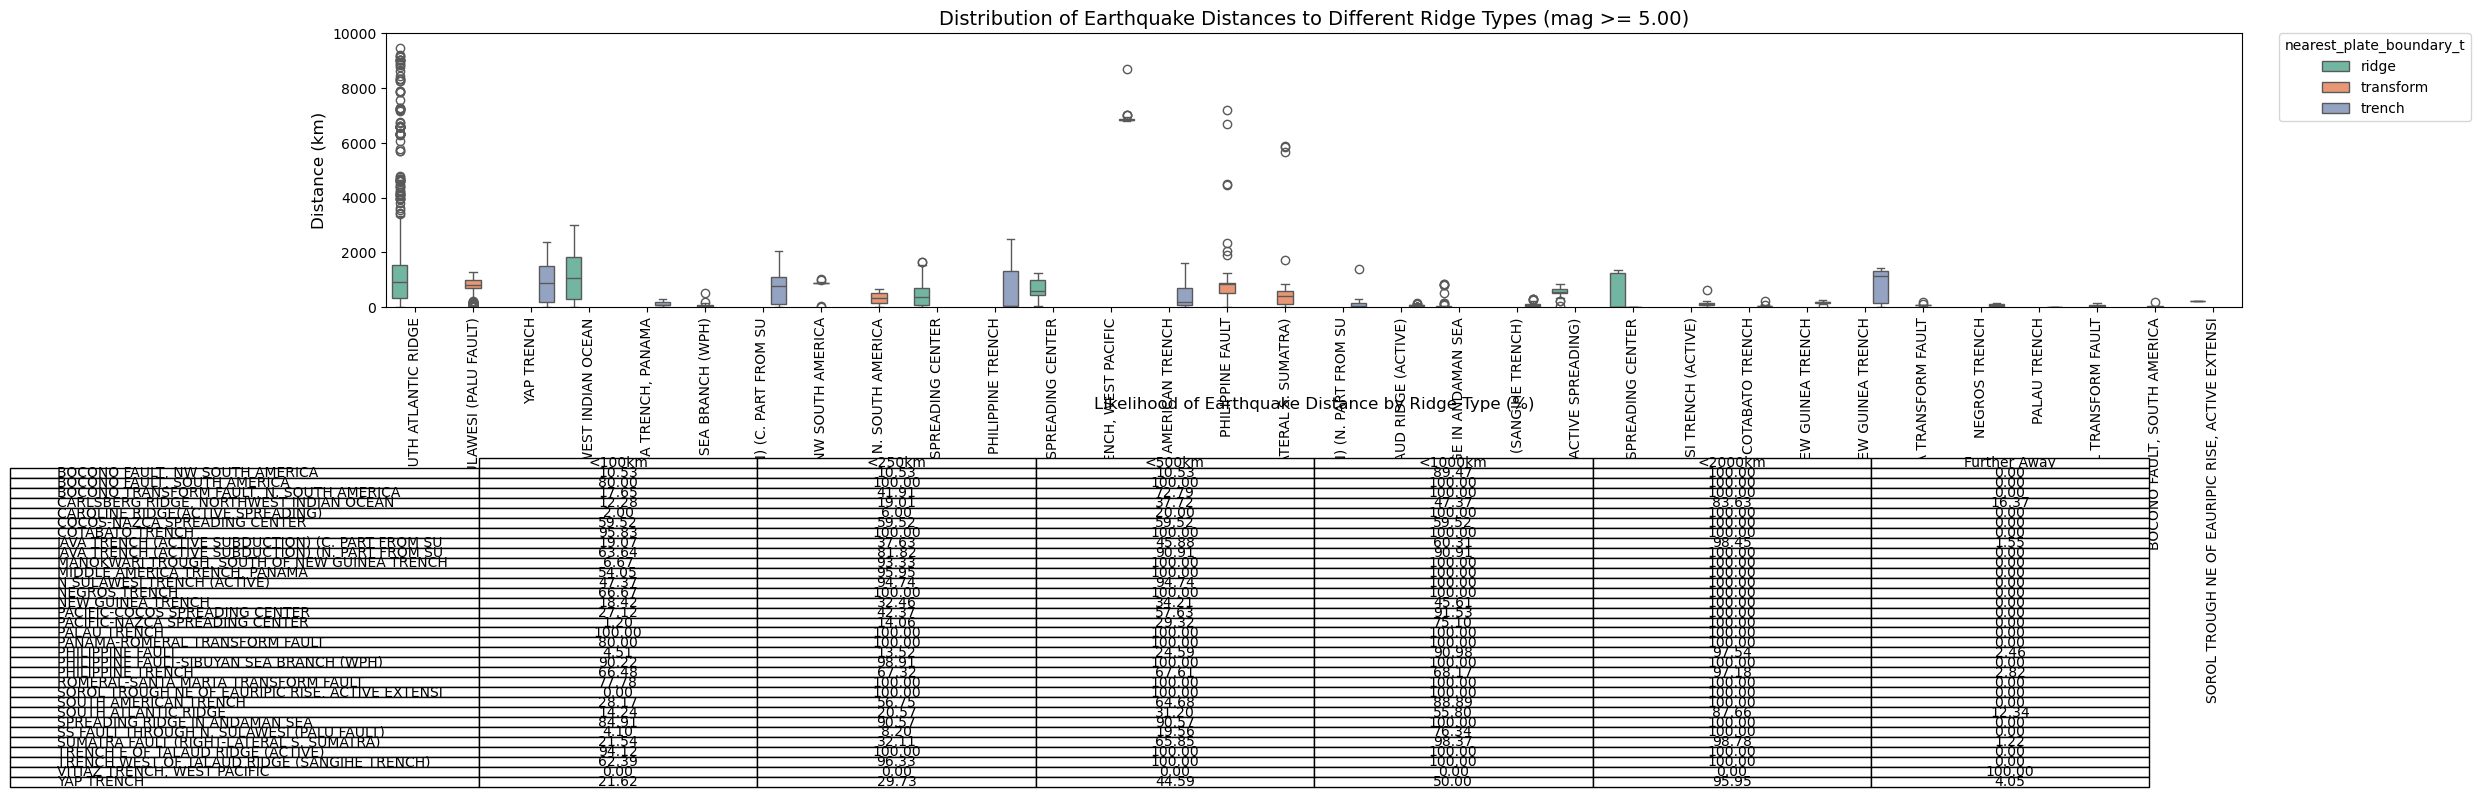

In [18]:
# Now call the function with the desired column
visualize_ridge_distance_likelihood_combined(
    earthquake_gdf_with_distances,
    distance_column='distance_to_plate_km',
    boundary_type_column='nearest_plate_geogdesc', # Use the alternative column
    distance_thresholds=[100, 250, 500, 1000, 2000],
    minmag=5.0,
    color_by='nearest_plate_boundary_t'
)